In [2]:
from fastai.text import *

## language model

In [4]:
data_lm = (TextList.from_folder('data/txt/train')
               .no_split()
               .label_for_lm()
               .databunch())

In [5]:
learn = language_model_learner(data_lm, AWD_LSTM)

In [7]:
learn.predict('this bird has', n_words=30, temperature=0.75)

'this bird has also made it one of the most well - rounded And Their Covers of the Way : The Way of the Two'

In [8]:
encoder = learn.model[0]

In [19]:
encoder.eval()
with torch.no_grad():
    for xb,yb in progress_bar(learn.data.train_dl):
        print(xb.shape)
        print(encoder(xb)[0][-1].shape)
        break

torch.Size([64, 70])
torch.Size([64, 70, 400])


In [20]:
learn.save_encoder('enc')

In [26]:
encoder = MultiBatchEncoder(70, 20*70, learn.model[0])

In [47]:
t=encoder(xb)

In [52]:
t[0][-1][:,-1].shape

torch.Size([64, 400])

In [37]:
gc.collect()

1409

In [38]:
def test_cat(arrs):
    return [torch.cat([l[si] for l in arrs], dim=1) for si in range_of(arrs[0])]

In [45]:
[l.shape for l in test_cat([torch.randn(4,5,10),torch.randn(4,5,10)])]

[torch.Size([5, 20]),
 torch.Size([5, 20]),
 torch.Size([5, 20]),
 torch.Size([5, 20])]

In [41]:
torch.randn(4,5)[2]

tensor([-1.4548, -0.7306,  1.0662,  0.4304, -0.3434])

In [46]:
torch.randn(3,4,5)[:,-1].shape

torch.Size([3, 5])

## classifier

In [2]:
def fn2class(fn):
    fields = os.path.basename(fn).split('_')
    return '_'.join(fields[:-3])

In [4]:
data_clas = (TextList.from_folder('data/txt/train')
               .split_by_rand_pct()
               .label_from_func(fn2class)
               .databunch())

In [5]:
data_clas.show_batch()

text,target
"xxbos this larger bird is duck - like and has a black and white body on which the black is mostly from the xxunk of the wings on back throughout xxunk rest of his body xxunk the breast , neck and throat are white with the exception of a brown xxunk patch and his bill is yellow and long . \n",Laysan_Albatross
"xxbos a well color xxunk small bird resting for a xxunk on a xxunk xxunk , a round grey beak leading back to a yellow xxunk that xxunk the eye surrounded by brownish grey ; the brownish grey gives way to yellow and then white down the bird 's back with a black tail and wing tips . \n",Evening_Grosbeak
"xxbos a bird with various hues of royal blue with a black and blue bill , black coloring on top of head , eye , and tips of a few tail feathers , reddish color on underside of tail , grayish black tarsus and feet that appears about 3 - xxunk xxunk long . \n",Gray_Catbird
"xxbos this bird is about xxunk xxunk from head to tail , the top of the head is black , the bottom of the head and neck are white , the wings are blueish and the belly is reddish - brown , the tail is black and blue with white stripes . \n",Ringed_Kingfisher
"xxbos this bird seems to be a medium size bird with very unique colors there is reddish brown , black , white , gray and gold / light brown color xxunk the xxunk of the bird this bird has a very small beak large eyes for its size and very long wings \n",Cliff_Swallow


In [6]:
data_clas.train_ds.classes, data_clas.c

(['American_Redstart',
  'Blue_Headed_Vireo',
  'Bobolink',
  'Bronzed_Cowbird',
  'Cactus_Wren',
  'Cape_Glossy_Starling',
  'Cardinal',
  'Carolina_Wren',
  'Caspian_Tern',
  'Cerulean_Warbler',
  'Cliff_Swallow',
  'Eastern_Towhee',
  'Elegant_Tern',
  'Evening_Grosbeak',
  'Fish_Crow',
  'Florida_Jay',
  'Gadwall',
  'Gray_Catbird',
  'Green_Kingfisher',
  'Green_Tailed_Towhee',
  'Hooded_Merganser',
  'Ivory_Gull',
  'Laysan_Albatross',
  'Loggerhead_Shrike',
  'Magnolia_Warbler',
  'Mourning_Warbler',
  'Northern_Fulmar',
  'Orchard_Oriole',
  'Prothonotary_Warbler',
  'Ring_Billed_Gull',
  'Ringed_Kingfisher',
  'Ruby_Throated_Hummingbird',
  'Scissor_Tailed_Flycatcher'],
 33)

In [7]:
data_clas.loss_func

FlattenedLoss of CrossEntropyLoss()

In [11]:
learn_c = text_classifier_learner(data_clas, AWD_LSTM, loss_func=LabelSmoothingCrossEntropy())

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


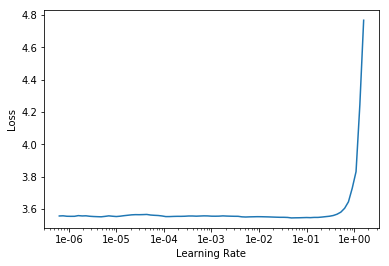

In [12]:
learn_c.lr_find()
learn_c.recorder.plot()

In [13]:
learn_c.fit_one_cycle(5, 1e-1, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.532287,3.555533,0.030691,01:57
1,3.584409,3.537302,0.031202,01:56
2,3.563182,3.577546,0.036317,01:55
3,3.526358,3.505183,0.025575,01:56
4,3.500615,3.503458,0.029668,01:55


In [14]:
encoder = learn_c.model[0].module

In [15]:
_ = encoder.eval()

In [16]:
fns = get_files('data/txt/train/', extensions=['.txt'])

In [17]:
len(fns), fns[0]

(9776, WindowsPath('data/txt/train/American_Redstart_0002_103723_0.txt'))

In [19]:
with open(fns[0], 'r') as f: txt = f.read()
xb,yb = learn_c.data.one_item(txt)

c:\users\wangpei\documents\github\fastai\fastai\torch_core.py:76: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


In [25]:
xb.size()

torch.Size([1, 15])

In [20]:
o = encoder(xb)

In [24]:
len(o), o[0][-1].size(), o[0][-1][:,-1].size()

(2, torch.Size([1, 15, 400]), torch.Size([1, 400]))

In [26]:
warnings.filterwarnings('ignore')

In [27]:
embedding = {}
with torch.no_grad():
    for fn in progress_bar(fns):
        with open(fn, 'r') as f: txt = f.read()
        xb,yb = learn_c.data.one_item(txt)
        embedding[os.path.basename(fn)] = encoder(xb)[0][-1][:,-1].view(400,1,1)        

In [28]:
len(embedding)

9776

In [29]:
torch.save(embedding, 'embedding_wk.pkl')

In [3]:
embedding = torch.load('embedding_wk.pkl')

In [4]:
for k in embedding:
    embedding[k] = embedding[k].cpu()

In [5]:
torch.save(embedding, 'embedding_wk.pkl')

In [10]:
a = list(Path('sample/txt/train/').glob('Cape_Glossy_Starling*'))[:3]
b = list(Path('sample/txt/train/').glob('Evening_Grosbeak*'))[:3]
c = list(Path('sample/txt/train/').glob('Orchard_Oriole*'))[:3]

In [7]:
def print_correlation(vs):
    for i in range(len(vs)):
        for j in range(i+1):
            print(nn.functional.cosine_similarity(embedding[vs[i].name], embedding[vs[j].name], dim=0).item(), end=',')
        print()

In [12]:
print_correlation(a)

1.0,
0.9999120831489563,0.9999999403953552,
0.9996751546859741,0.9995993971824646,1.0000001192092896,


In [14]:
print_correlation(list(zip(a,b,c))[0])

1.0,
0.9996569752693176,0.9999998211860657,
0.9996308088302612,0.9995120167732239,1.0,
